In [12]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import negative_sampling
import networkx as nx
import math
from random import choice
from functools import lru_cache
from sympy import prime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Link prediction using enclosing subgraphs on a social network dataset
Project for course "Introduction to network science"
Viktor Mladenovski (viktor.mladenovski@students.finki.ukim.mk), Faculty of Computer Science and Engineering

## Introduction and motivation

In recent years, the field of network science has played a pivotal role in unraveling the intricate dynamics of interconnected systems, ranging from social networks to biological pathways. The analysis of networked structures offers insights into the underlying relationships and dependencies among entities, enabling a deeper understanding of complex systems. Within this context, the present explores the applicability of a specific link prediction algorithm (Palette-WL [1]) in a network dataset [2] derived from the Twitch, a platform for live game streaming and interactive engagement.

The networks in the dataset contain nodes as individual users and links as mutual "follows" relationships between them. With Twitch serving as a multifaceted platform where communities converge around shared interests, the dynamics of user interactions give rise to a rich tapestry of connections, embodying social structures within the digital landscape. The primary focus of this investigation lies in forecasting the latent relationships that may emerge within this dynamic environment, employing traditional methodologies (in contrast to GNNs) from the field of network science.

The significance of link prediction within the Twitch network is underscored by its potential to enhance user experience, community building, and platform engagement. By forecasting prospective connections between users, platforms like this can strategically tailor recommendations, foster community cohesion, and provide personalized content experiences. Moreover, understanding the underlying principles governing link formation contributes to the broader discourse on network evolution, offering theoretical insights into the dynamics of social interactions in online environments.

The ensuing analysis aims to unravel patterns of link formation, assess the predictive accuracy of the chosen model, and discern factors influencing the establishment of connections among users. By doing so, this study seeks to contribute to the evolving landscape of network science, with implications extending to both theoretical advancements and practical applications within the burgeoning realm of digital social networks.

## Dataset and model choice
<br/>

|              | DE     | EN    | ES    | FR     | PT    | RU    |
|--------------|--------|-------|-------|--------|-------|-------|
| # Nodes      | 9498   | 7126  | 4648  | 6549   | 1912  | 4385  |
| # Edges      | 153138 | 35324 | 59382 | 112666 | 31299 | 37304 |
| Density      | 0.003  | 0.002 | 0.006 | 0.005  | 0.017 | 0.004 |
| Transitivity | 0.047  | 0.042 | 0.084 | 0.054  | 0.131 | 0.049 |
*Summary of the 6 networks*

<br/>

The musae-twitch dataset contains six distinct networks, each corresponding to a unique language and region, which encapsulates the socially and culturally diverse nature of user interactions within the online community. These language-specific networks serve as "small worlds" of sorts, since they also contain separate communities within themselves, for example fans of specific games or broader genres of games (e.g. shooters, strategies, sports games etc.).

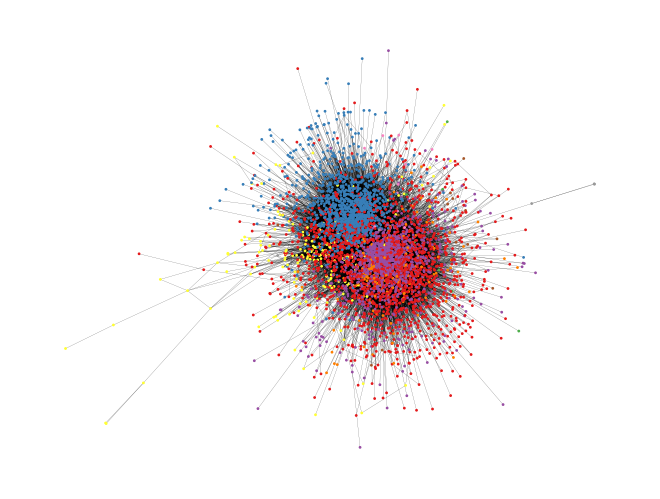

In [11]:
# Louvain community detection on Spanish-speaking network

It is important to note that the dataset not only contains structural information in the form of user-user connections but also has a wealth of node features. For each user node, there are 3169, providing a comprehensive characterization of individual users based on various attributes. These attributes may range from streaming habits and content preferences to engagement metrics (the exact meanings of each feature are not disclosed by the authors since they allegedly contain sensitive data [3]). However, for the purposes of this study, we will exclusively focus on leveraging **purely structural information**.

The decision to rely solely on the structural information is due to the adoption of the Palette-WL algorithm, which has been partially reimplemented and its testing is one of the goals of this project. The said algorithm, which will be explained in more detail in further sections, allows for the extraction of topological patterns from the network without explicitly considering node attributes. By disregarding the node features in the initial phase of analysis, the study aims to assess the inherent predictive power of the structural network topology, while also acknowledging that incorporation of node features is very likely enhance predictive performance. An example of node, and consequently edge embeddings significantly improving the precision and AUC scores of subgraph-based approaches for link prediction in citation networks is well documented in [4].

### Some properties of networks in dataset

For brevity, only Spanish network is taken as an example, although all networks exhibit more or less similar properties

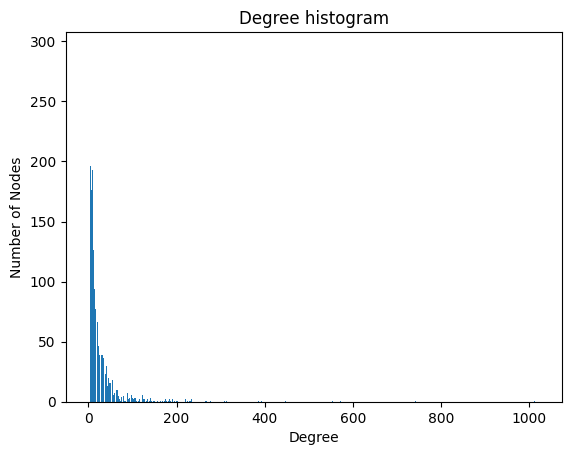

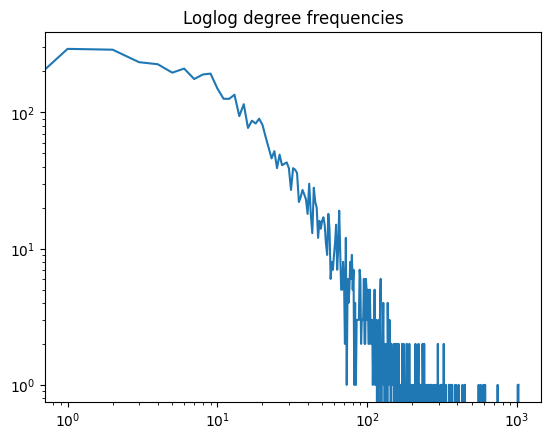

In [49]:
# Degree histogram and loglog plot of degree frequencies for Spanish-speaking network

### Centrality with PageRank

Top 20 nodes:

<br/>

| Node ID | Score                   |
|---------|-------------------------|
| 1565    | 0.004584898162223154    |
| 982     | 0.004370308860462088    |
| 4142    | 0.004197037265617364    |
| 2864    | 0.00403195010088056     |
| 940     | 0.0034545138265099566   |
| 4397    | 0.0033616135319110606   |
| 781     | 0.0033202493731297397   |
| 2922    | 0.0030695267942637354   |
| 182     | 0.002818463686262599    |
| 4607    | 0.0027694670009223922   |
| 1397    | 0.002766012881371078    |
| 1084    | 0.0027413968935102286   |
| 68      | 0.002679029662099128    |
| 1351    | 0.002678743786710921    |
| 1890    | 0.002443383666587371    |
| 724     | 0.002410569734476015    |

## The Palette-WL Algorithm

The core idea behind the solution proposed by Muhan Zhang and Yixin Chen in their 2017 paper "Weisfeiler-Lehman Neural Machine for Link Prediction" is to encode information about the structure of the fixed-size subgraph surrounding each link in the graph and use that information (e.g. their adjacency matrices) for training a classifier. Neural networks and logistic regression are used in the original paper, while in this study only the logistic regression model is reproduced. These subgraphs are referred to as *enclosing subgraphs* and, for a given edge $e$ and subgraph size $K$, are constructed by initializing a set $S$ with the nodes forming $e = (x,y)$, after which we add the first order neighbors of $x$ and $y$, then the second order neighbors etc. until we have at least $K$ nodes. We want exactly K nodes in the subgraph, since we will be using flattened versions of their adjacency matrices as feature vectors for training. However, it's possible that the process above results in $|S|<K$ or $|S|>K$. Therefore, if the procedure leads to less than $K$ nodes, then random nodes from the graph are sampled until we reach that number. If we end up with more than $K$ nodes, the solution used by the authors is to first impose an order on $S$ and then start removing the least important nodes first until $|S|=K$. For simplicity, the solution chosen in this reimplementation is to remove the last added nodes.
The problem now is: how do we retain the fact that an enclosing subgraph corresponds to the edge it was extracted from or, intuitively, how the classifier will recognize this fact when given a sample to train on or predict. One way of achieving what we want is to somehow sort the adjacency matrix, so that the rows representing the nodes which form the link are always in the same position (for example, first and second). Since topological sorting isn't possible on undirected graphs, another way to impose an ordering on the vertex set is to use *color refinement*. In principle, this term can refer to any algorithm which partitions the vertex set in such a way that vertices with similar properties end up in the same partition. We want this partitioning to be by the structural roles of the nodes. Below is an example of such a partitioning due to Weisfeiler and Lehman, which has many different uses in machine learning on graphs (we can use the result of the color refinement step to get node embeddings or graph embeddings, too).

*Weisfeiler-Lehman color refinement on example graph*
*Source: http://snap.stanford.edu/class/cs224w-2020/slides/02-tradition-ml.pdf*

![Weisfeiler-Lehman color refinement example](wl-example.png)

In order for the edge-forming nodes to have the smallest resulting colors by the end, we can try setting their initial colors to 1 and 2, and some other color $>2$ for all other nodes. In the paper by Zhang and Chen and in this reproduction, the edge-forming nodes are assigned colors 1 and 2, while all others node get a color which is based on their geometric mean distance to the target link: if $d_H(i,j)$ denotes the length of the shortest path from node $i$ to node $j$ in the enclosing subgraph $H$, then we define the mean distance for a node $v$ to the target edge $(x,y)$ as $m(v,x,y) := \sqrt{d_H(v,x) d_H(v,y)}$. To get the colors after finding the mean distance for every node, in computer science jargon, we first store them in an array and sort that array in ascending order. Then, we assign $3+\textrm{idx}(m(v,x,y))$ as the color for node $v$ where $\textrm{idx}$ is the index of the mean distance value in the 0-indexed array.

The problem with the original algorithm is that it's not *color order preserving*, meaning it won't guarantee that nodes with the smallest colors initially will still have the smallest colors after the refinement. In general, the property we want can be described as follows: if $c(v_i)$ and $c(v_j)$ are the colors of nodes $i$ and $j$ respectively and initially $c(v_i) \geq c(v_j)$, then the same inequality holds after refining. On the other hand, *Palette-WL* is a modified algorithm which can be proven to have this property. In it, we iteratively apply the perfect (colisionless) hash function shown below to each node in the subgraph until there is no change in colors between iterations. Since outputs of the hash function can be any real number, we apply a procedure analogous to the one explained previously (for the mean distances) in order to obtain integer colors.

<br/>

$$h(x) = c(x) + \frac{1}{\lceil \sum_{z \in V_K}{\log (\mathcal{P(c(z))})}\rceil} \cdot \sum_{z' \in \mathcal{N}(x)}{\log(\mathcal{P}(c(z)))}$$

where $V_K$ is the set of all nodes in the subgraph, $\mathcal{P}(n)$ is the $n$th prime number and $\mathcal{N}(x)$ is the set of neighboring nodes of $x$.

The final challenge is the fact that the colors after applying *Palette-WL* don't impose a strict order i.e. nodes can have same colors after convergence. These ties can be broken by finding a canonical labelling of the subgraph using B.D. McKay's algorithm (Nauty) [5]. The exact tie-breaking algorithm isn't explained in detail in Zhang and Chen's paper, however one possibility is given in [6]. Regardless, these ties don't occur frequently enough in practice (almost never on the musae-twitch dataset) to warrant a reimplementation, so we will resort to using a simpler method - chosing a random ordering for the nodes with the same color.

## Model training

Now that we have representations of the enclosing subgraphs which preserve information about the edge they were produced from (their sorted adjacency matrices), the final step of the preprocessing is to flatten them and feed them as labeled vectors to a logistic regression classifier. It's worth noting that, for achieving better performance, the authors of this approach suggest enriching the sorted adjacency matrix by having $A_{i,j}$ hold information about the length of the shortest path between edges $(i,j)$ and $(x,y)$ (the target edge), instead of just a binary value indicating the presence or absence of the $(i,j)$ edge. This step is omitted in the Python implementation below.

To train a binary classifier, we need negative samples too, therefore synthetic negative samples are generated using PyTorch Geometric's `negative_sampling` function. As prescribed in [1], during both training and testing, a 2-1 ratio of negative to positive samples is used. For training, we hide a portion of the edges, add negative samples to what remains, and then compute the feature vectors for both positive and negative edges, labelling them accordingly. During testing, we construct a graph which contains the real training and testing edges, as well as synthetic negative testing edges. Finally, we compute the feature vectors for the test set. The edgelist files in the `data` folder were split in a 70%-30% manner using awk's `rand` function to produce `musae_[LANG]_train.edgelist` and `musae_[LANG]_test.edgelist`. When evaluating the model it's important to note that both training and testing data contain noise, since, for whatever reason, the PyTorch Geometric's `negative sampling` function produces a small fraction (around 0.2-0.3%) of positive edges.

## Results

<br/>

|      | Accuracy | ROC AUC |
|------|----------|---------|
| ES   | 0.805    | 0.855   |
| ENGB | 0.805    | 0.851   |
| FR   | 0.792    | 0.841   |
| RU   | 0.786    | 0.829   |
| DE   | 0.798    | 0.842   |
| PTBR | 0.798    | 0.846   |

*Accuracy and ROC AUC scores after single experiment*

<br/>

Additional testing on the Yeast dataset - a protein interaction network [7].

<br/>


|       | Accuracy | ROC AUC |
|-------|----------|---------|
| Yeast | 0.784    | 0.816   |


## References
[1] Zhang, M., Chen, Y., Weisfeiler-Lehman Neural Machine for Link Prediction (https://muhanzhang.github.io/papers/KDD_2017.pdf)

[2] Rozemberczki, B., Allen, C., Sarkar, R., Multi-scale Attributed Node Embedding (https://arxiv.org/abs/1909.13021)

[3] https://github.com/benedekrozemberczki/MUSAE/issues/3

[4] Diao, Z., Link Prediction with Enclosing Subgraph (http://snap.stanford.edu/class/cs224w-2018/reports/CS224W-2018-64.pdf)

[5] McKay, B.D. and Piperno, A., Practical Graph Isomorphism, II, Journal of Symbolic Computation, 60 (2014), pp. 94-112 (https://www.sciencedirect.com/science/article/pii/S0747717113001193?via%3Dihub)

[6] https://math.stackexchange.com/questions/4848985/graph-canonization-for-breaking-ties-in-colored-graph

[7] http://vlado.fmf.uni-lj.si/pub/networks/data/bio/Yeast/Yeast.htm

# Implementation

In [2]:
with open('musae_ES/musae_ES_train.edgelist', 'r') as file:
    lines = file.readlines()

train_edges = []

for line in lines:
    elements = line.strip().split()
    edge = (int(elements[0]), int(elements[1]))
    train_edges.append(edge)

In [3]:
def enclosing_subgraph_nodes(G, x, y, K):
    F = {x, y}
    enc = [x, y]

    while len(enc) < K:
        new_neighbors = set()
        for node in F:
            neighbors = [v for v in list(G.neighbors(node)) if v not in F and v not in enc]
            new_neighbors.update(neighbors)

        if not new_neighbors:
            break  # Break if no new neighbors are found

        enc.extend(new_neighbors)
        F = new_neighbors

    # Trim down or add random dummy nodes as needed
    if len(enc) > K:
        enc = enc[:K]
    elif len(enc) < K:
        while len(enc) < K:
            random_dummy_node = choice([node for node in G.nodes() if node not in enc])
            enc.append(random_dummy_node)

    return enc

In [4]:
def initialize_colors(H, x, y):
    # to get initial colors, first need to calculate sqrt(d(v,x)*d(v,y)) for all v in node set
    mean_distances = {}
    for v in H.nodes():
        if nx.has_path(H, v, x) and nx.has_path(H, v, y):
            distance = math.sqrt(len(nx.shortest_path(H, v, x)) * len(nx.shortest_path(H, v, y)))
            mean_distances[v] = distance
        else:
            # Handle the case when there is no path between v and x or v and y
            mean_distances[v] = float('inf')  # or any other appropriate value

    # then need to map distances to colors s.t. only x=y=1 while all others get at least 2
    # depending on their mean distance

    initial_coloring = {x: 1, y: 1}

    ordering = sorted(set(mean_distances.values()))[1:]

    for v in H.nodes():
        if v not in {x, y}:
            initial_coloring[v] = 2 + ordering.index(mean_distances[v])

    return initial_coloring


In [5]:
@lru_cache(maxsize=None)
def hash_fun(v, H, **kwargs):
    current_color_v = kwargs[str(v)]

    all_mapping = {z: math.log(prime(kwargs[z])) for z in kwargs.keys()}
    neighborhood_mapping = {z: all_mapping[str(z)] for z in H.neighbors(v)}

    sum_all_mapping = sum(all_mapping.values())
    sum_neighborhood_mapping = sum(neighborhood_mapping.values())

    return current_color_v + sum_neighborhood_mapping / math.ceil(sum_all_mapping)

In [ ]:
# single iteration of palette_wl, returns colors (doesn't mutate H labels)
def refine(color_dict, H):
    hashes = {v:hash_fun(v, H, **{str(k): v for k, v in color_dict.items()}) for v in color_dict.keys()}

    coloring = {}

    ordering = sorted(set(hashes.values()))

    for v in color_dict.keys():
      coloring[v] = ordering.index(hashes[v]) + 1

    return coloring

In [7]:
# 'color' attributes of H are NOT mutated by this fn either
def palette_wl(color_dict, H):
  num_iter = 0
  
  while True:
    new_color_dict = refine(color_dict, H)

    # convergence condition
    if color_dict == new_color_dict:
      break
    else:
      color_dict = new_color_dict
      num_iter += 1

  return color_dict
    
  # print(f'Converged in {num_iter} iterations')

In [8]:
def break_ties(color_dict):
    reversed_mapping = {}  # to keep track of nodes with the same color
    new_color = max(color_dict.values()) + 1  # start assigning new colors

    for node, color in color_dict.items():
        if color in reversed_mapping:
            # node with the same color already encountered
            # assign a new color and update the mapping
            color_dict[node] = new_color
            new_color += 1
        else:
            reversed_mapping[color] = node

    return color_dict

In [9]:
def process_graph(edge, H):
    x,y = edge
    initial_color_dict = initialize_colors(H, x, y)
    refined_color_dict = palette_wl(initial_color_dict, H)
    color_dict_no_ties = break_ties(refined_color_dict)
    
    sorted_nodes = sorted(color_dict_no_ties, key=color_dict_no_ties.get)
    
    return nx.to_numpy_array(H, nodelist=sorted_nodes)

In [10]:
def flatten_matrix(matrix, exclude_indices): # exclude (1,0) and (0,1) which encode existence of link
    flattened_matrix = []

    for i in range(len(matrix)):
        for j in range(i + 1, len(matrix[i])):
            if (i, j) not in exclude_indices and (j, i) not in exclude_indices:
                flattened_matrix.append(matrix[i][j])

    return flattened_matrix

In [11]:
G = nx.from_edgelist(train_edges)
G.remove_edges_from(nx.selfloop_edges(G))

extracted_subgraphs = {}

for (i,j) in train_edges:
    if i != j: # ignore self loops
        enclo_nodes = enclosing_subgraph_nodes(G, i, j, 10)
        H = G.subgraph(enclo_nodes)
        extracted_subgraphs[(i,j)] = H

In [12]:
transformed_adj_matrices = {}

for edge, H in tqdm(extracted_subgraphs.items()):
    transformed_adj_matrices[edge] = process_graph(edge,H)

100%|██████████| 41692/41692 [21:24<00:00, 32.46it/s]  


Generate synthetic negative edges (edges not in edges_train) and repeat procedure for them (enclo. subgraph -> sorted adj. matrix). 
These are used only for training the classifier.

In [13]:
negative_edges = negative_sampling(torch.as_tensor(np.transpose(train_edges)), force_undirected=False, num_neg_samples=2*len(train_edges))

negative_edges_list = []

for i in range(len(negative_edges[0])):
    negative_edges_list.append((int(negative_edges[0][i]),int(negative_edges[1][i])))

G_fake = nx.from_edgelist(train_edges)
G_fake.add_edges_from(negative_edges_list)
G_fake.remove_edges_from(nx.selfloop_edges(G_fake))

extracted_subgraphs_fake = {}

for (i,j) in negative_edges_list:
    if i != j: # ignore self loops
        enclo_nodes = enclosing_subgraph_nodes(G_fake, i, j, 10)
        H_fake = G_fake.subgraph(enclo_nodes)
        extracted_subgraphs_fake[(i,j)] = H_fake

transformed_adj_matrices_fake = {}

for edge_fake, H_fake in tqdm(extracted_subgraphs_fake.items()):
    transformed_adj_matrices_fake[edge_fake] = process_graph(edge_fake,H_fake)

100%|██████████| 83384/83384 [09:19<00:00, 149.04it/s]


In [14]:
cnt=0
for i,j in negative_edges_list:
    if G.has_edge(i,j) or G.has_edge(j,i):
        cnt+=1 
cnt

164

Prepare training data

In [15]:
train_data = []

for matrix in transformed_adj_matrices.values():
    flattened_matrix = flatten_matrix(matrix, {(0, 1), (1, 0)})
    train_data.append({'label':1, 'features': flattened_matrix})


for matrix in transformed_adj_matrices_fake.values():
    flattened_matrix = flatten_matrix(matrix, {(0, 1), (1, 0)})
    train_data.append({'label':0, 'features': flattened_matrix})  
        

train_df = pd.DataFrame(train_data)
train_df_shuffled = train_df.iloc[np.random.permutation(len(train_df))].reset_index(drop=True)

In [16]:
X = np.vstack(train_df_shuffled['features'].to_numpy())
y = train_df_shuffled['label'].to_numpy()

classifier = LogisticRegression(max_iter=100, solver='liblinear')

classifier.fit(X,y)

LogisticRegression(solver='liblinear')

Extract enclosing subgraphs for test edges and compute sorted adjacency matrices 

In [17]:
with open('musae_ES/musae_ES_test.edgelist', 'r') as file:
    lines = file.readlines()

test_edges = []

for line in lines:
    elements = line.strip().split()
    edge = (int(elements[0]), int(elements[1]))
    test_edges.append(edge)

G_test = nx.from_edgelist(train_edges)
G_test.add_edges_from(test_edges)
G_test.remove_edges_from(nx.selfloop_edges(G_test))

extracted_test_subgraphs = {}

for (i,j) in test_edges:
    if i != j: # ignore self loops
        enclo_nodes = enclosing_subgraph_nodes(G_test, i, j, 10)
        H_test = G_test.subgraph(enclo_nodes)
        extracted_test_subgraphs[(i,j)] = H_test

transformed_adj_matrices_test = {}

for edge_test, H_test in tqdm(extracted_test_subgraphs.items()):
    transformed_adj_matrices_test[edge_test] = process_graph(edge_test,H_test)

100%|██████████| 17690/17690 [12:27<00:00, 23.68it/s] 


Generate synthetic negative samples for testing (edges not in test_edges OR train_edges) and do same procedure for them as above

In [18]:
# make sure negative samples are truly negative 
train_union_test = train_edges + test_edges
negative_test_edges = negative_sampling(torch.as_tensor(np.transpose(train_union_test)), force_undirected=False, num_neg_samples=2*len(test_edges))

negative_test_edges_list = []

for i in range(len(negative_test_edges[0])):
    negative_test_edges_list.append((int(negative_test_edges[0][i]),int(negative_test_edges[1][i])))
    

G_fake_test = nx.from_edgelist(train_edges)
G_fake_test.add_edges_from(negative_test_edges_list)
G_fake_test.remove_edges_from(nx.selfloop_edges(G_fake_test))

extracted_subgraphs_fake_test = {}

for (i,j) in negative_test_edges_list:
    if i != j: # ignore self loops
        enclo_nodes = enclosing_subgraph_nodes(G_fake_test, i, j, 10)
        H_fake_test = G_fake_test.subgraph(enclo_nodes)
        extracted_subgraphs_fake_test[(i,j)] = H_fake_test

transformed_adj_matrices_fake_test = {}

for edge_fake_test, H_fake_test in tqdm(extracted_subgraphs_fake_test.items()):
    transformed_adj_matrices_fake_test[edge_fake_test] = process_graph(edge_fake_test,H_fake_test)

100%|██████████| 35380/35380 [06:42<00:00, 87.91it/s] 


In [19]:
cnt=0
for i,j in negative_test_edges_list:
    if G_test.has_edge(i,j) or G_test.has_edge(j,i):
        cnt+=1 
cnt

93

Prepare test data

In [20]:
test_data = []

for matrix in transformed_adj_matrices_test.values():
    flattened_matrix = flatten_matrix(matrix, {(0, 1), (1, 0)})
    test_data.append({'label':1, 'features': flattened_matrix})

for matrix in transformed_adj_matrices_fake_test.values():
    flattened_matrix = flatten_matrix(matrix, {(0, 1), (1, 0)})
    test_data.append({'label':0, 'features': flattened_matrix})  

test_df = pd.DataFrame(test_data)
test_df_shuffled = test_df.iloc[np.random.permutation(len(test_df))].reset_index(drop=True)
print(test_df_shuffled)

       label                                           features
0          1  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
1          0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2          0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3          0  [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
4          0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
...      ...                                                ...
53065      0  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
53066      0  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
53067      0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
53068      0  [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...
53069      1  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...

[53070 rows x 2 columns]


Results

In [21]:
X_test = np.vstack(test_df_shuffled['features'].to_numpy())
y_test = test_df_shuffled['label'].to_numpy()

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.10f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8046542303
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     35380
           1       0.70      0.72      0.71     17690

    accuracy                           0.80     53070
   macro avg       0.78      0.78      0.78     53070
weighted avg       0.81      0.80      0.81     53070


In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

0.8552546278617265